## Results and Graphs

### Combine results in to One CSV file

In [3]:
import pandas as pd
import os, re

# ---- paths ----
PHQ9_CSV   = "Analysis/PHQ9/Questionnaire_summary.csv"
GAD7_CSV   = "Analysis/GAD7/Questionnaire_summary.csv"
ASRM_CSV   = "Analysis/ASRM/Questionnaire_summary.csv"
CASUAL_CSV = "Analysis/Casual/Casual_summary.csv"

OUT_CSV    = "Analysis/Combined_scores.csv"
os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)

# ---- helpers ----
def norm_name(s):
    if pd.isna(s): 
        return ""
    s = str(s).strip().lower()
    s = s.replace("_", " ").replace("-", " ")
    s = re.sub(r"\s+", " ", s)
    return s

def load_score(csv_path, total_cols, name_cols=("Name","character","persona"), label="Score"):
    """Load a CSV and return df[name_key, label] using the best matching total column."""
    df = pd.read_csv(csv_path)

    # find name col
    name_col = None
    for c in df.columns:
        if c in name_cols or c.lower() in [n.lower() for n in name_cols]:
            name_col = c
            break
    if name_col is None:
        raise ValueError(f"Name column not found in {csv_path}. Got: {list(df.columns)}")

    # find total col
    total_col = None
    for cand in total_cols:
        for c in df.columns:
            if c.lower() == cand.lower():
                total_col = c
                break
        if total_col:
            break
    if total_col is None:
        raise ValueError(f"Total column not found in {csv_path}. Tried {total_cols}, got {list(df.columns)}")

    out = pd.DataFrame({
        "Name_raw": df[name_col],
        label: pd.to_numeric(df[total_col], errors="coerce")
    })
    out["name_key"] = out["Name_raw"].map(norm_name)
    return out

# ---- load each source ----
phq9_df   = load_score(PHQ9_CSV,   total_cols=["Total","PHQ9_Total"],                label="PHQ9_Score")
gad7_df   = load_score(GAD7_CSV,   total_cols=["Total","GAD7_Total"],                label="GAD7_Score")
asrm_df   = load_score(ASRM_CSV,   total_cols=["Total","ASRM_Total"],                label="ASRM_Score")
casual_p  = load_score(CASUAL_CSV, total_cols=["PHQ9_Total"],                        label="PHQ9_Estimate")
casual_g  = load_score(CASUAL_CSV, total_cols=["GAD7_Total"],                        label="GAD7_Estimate")
casual_a  = load_score(CASUAL_CSV, total_cols=["ASRM_Total"],                        label="ASRM_Estimate")

# For casual_* we only need name_key + estimate column
casual_p = casual_p[["name_key","PHQ9_Estimate"]]
casual_g = casual_g[["name_key","GAD7_Estimate"]]
casual_a = casual_a[["name_key","ASRM_Estimate"]]

# ---- merge all on normalized name_key ----
df = phq9_df.merge(gad7_df[["name_key","GAD7_Score"]], on="name_key", how="outer")
df = df.merge(asrm_df[["name_key","ASRM_Score"]], on="name_key", how="outer")
df = df.merge(casual_p, on="name_key", how="left")
df = df.merge(casual_g, on="name_key", how="left")
df = df.merge(casual_a, on="name_key", how="left")

# Prefer a clean Name column from PHQ9; fall back to others
def pick_name(row):
    for col in ["Name_raw", "Name_raw_x", "Name_raw_y"]:
        if col in row and isinstance(row[col], str) and row[col].strip():
            return row[col]
    return None

if "Name_raw" not in df.columns:
    # handle possible suffix columns from merges
    name_cols = [c for c in df.columns if c.startswith("Name_raw")]
else:
    name_cols = ["Name_raw"]

df["Name"] = df.apply(pick_name, axis=1)

# Keep only required columns
final = df[[
    "Name",
    "PHQ9_Score",
    "PHQ9_Estimate",
    "GAD7_Score",
    "GAD7_Estimate",
    "ASRM_Score",
    "ASRM_Estimate"
]].copy()

# Drop rows with no name at all
final = final[final["Name"].notna()].reset_index(drop=True)

# Save + peek
final.to_csv(OUT_CSV, index=False, encoding="utf-8")
print(f"✅ Combined scores saved → {OUT_CSV}")
display(final.head(20))


✅ Combined scores saved → Analysis/Combined_scores.csv


,Name,PHQ9_Score,PHQ9_Estimate,GAD7_Score,GAD7_Estimate,ASRM_Score,ASRM_Estimate
0,Abigail Hall,15,12,19,18,11,2
1,Abigail Johnson,6,8,7,6,11,6
2,Adriana Lopez,8,8,7,12,11,8
3,Aiden Scott,3,5,2,6,10,7
4,Aiden Smith,9,13,15,17,9,7
5,Aiden White,9,14,14,15,11,11
6,Alice Thompson,6,5,4,9,9,5
7,Alyssa Taylor,9,8,6,10,9,3
8,Alyssa Turner,8,6,13,10,9,7
9,Amelia Lopez,5,9,4,11,11,8


### Slatterplot for Score and Estimate

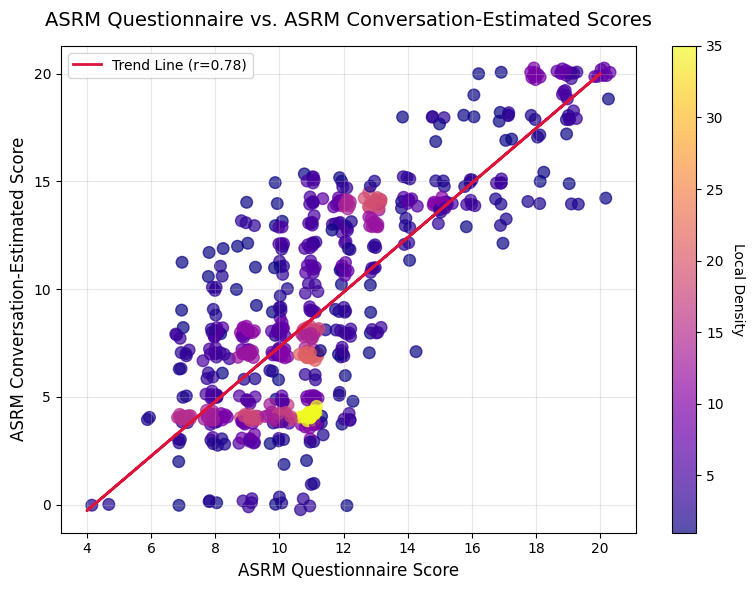

✅ Scatter plot saved to: Graphs\ASRM_Score_vs_ASRM_Estimate_Scatter_20251121_125525.png


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

# --- Load combined data ---
df = pd.read_csv("Analysis/combined_sorted.csv")

# --- Filter & clean ---
df = df.dropna(subset=["ASRM_Score", "ASRM_Estimate"])
df = df[(df["ASRM_Score"] >= 0) & (df["ASRM_Estimate"] >= 0)]

# --- Compute correlation ---
corr = df["ASRM_Score"].corr(df["ASRM_Estimate"])

# --- Create output directory for graphs ---
GRAPH_DIR = "Graphs"
os.makedirs(GRAPH_DIR, exist_ok=True)

# --- Build filename with timestamp ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
out_path = os.path.join(GRAPH_DIR, f"ASRM_Score_vs_ASRM_Estimate_Scatter_{timestamp}.png")

# --- Apply jitter to reduce overlap ---
rng = np.random.default_rng(42)
df["ASRM_Score_jitter"] = df["ASRM_Score"] + rng.normal(0, 0.15, len(df))
df["ASRM_Estimate_jitter"] = df["ASRM_Estimate"] + rng.normal(0, 0.15, len(df))

# --- Estimate density using 2D histogram (no SciPy needed) ---
counts, xedges, yedges = np.histogram2d(
    df["ASRM_Score_jitter"], df["ASRM_Estimate_jitter"], bins=25
)
x_idx = np.searchsorted(xedges, df["ASRM_Score_jitter"]) - 1
y_idx = np.searchsorted(yedges, df["ASRM_Estimate_jitter"]) - 1
x_idx = np.clip(x_idx, 0, counts.shape[0] - 1)
y_idx = np.clip(y_idx, 0, counts.shape[1] - 1)
density = counts[x_idx, y_idx]

# --- Create scatter plot (no edgecolors) ---
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    df["ASRM_Score_jitter"], df["ASRM_Estimate_jitter"],
    c=density, s=70, cmap='plasma', alpha=0.7  # No edgecolors
)

# --- Add regression line ---
m, b = np.polyfit(df["ASRM_Score"], df["ASRM_Estimate"], 1)
plt.plot(df["ASRM_Score"], m * df["ASRM_Score"] + b,
         color="crimson", linewidth=2, label=f"Trend Line (r={corr:.2f})")

# --- Labels, title, style ---
plt.title("ASRM Questionnaire vs. ASRM Conversation-Estimated Scores", fontsize=14, pad=15)
plt.xlabel("ASRM Questionnaire Score", fontsize=12)
plt.ylabel("ASRM Conversation-Estimated Score", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()

# --- Add colorbar ---
cbar = plt.colorbar(sc)
cbar.set_label("Local Density", rotation=270, labelpad=15)

# --- Tight layout and save ---
plt.tight_layout()
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Scatter plot saved to: {out_path}")


### Distribution of each condition

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Optional: a nicer overall style
plt.style.use("ggplot")

# Load your data (update path if needed)
df = pd.read_csv("Analysis/combined_sorted.csv")  # or your full path

def plot_distribution(series, title, xlabel, filename, color):
    data = series.dropna()

    plt.figure(figsize=(8, 6), dpi=120)

    # Histogram
    plt.hist(
        data,
        bins=20,
        color=color,
        edgecolor="white",   # clear bin edges
        alpha=0.85
    )

    # Mean line
    mean_val = data.mean()
    plt.axvline(mean_val, linestyle="--", linewidth=2)
    plt.text(
        mean_val, plt.ylim()[1]*0.95,
        f"Mean = {mean_val:.1f}",
        ha="center", va="top"
    )

    # Titles and labels
    plt.title(title, fontsize=14, pad=10)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)

    # Grid for readability
    plt.grid(axis="y", alpha=0.4)

    plt.tight_layout()
    plt.savefig(filename)
    plt.close()


# 1. PHQ9
plot_distribution(
    df["PHQ9_Score"],
    title="PHQ9 Score Distribution",
    xlabel="PHQ9 Score",
    filename="Graphs/PHQ9-Distribution.png",
    color="lightcoral"
)

# 2. GAD7
plot_distribution(
    df["GAD7_Score"],
    title="GAD7 Score Distribution",
    xlabel="GAD7 Score",
    filename="Graphs/GAD7-Distribution.png",
    color="lightsteelblue"
)

# 3. ASRM
plot_distribution(
    df["ASRM_Score"],
    title="ASRM Score Distribution",
    xlabel="ASRM Score",
    filename="Graphs/ASRM-Distribution.png",
    color="skyblue"
)

print("All enhanced plots saved!")


All enhanced plots saved!


### Accuracy of each Condition estimates

In [25]:
import pandas as pd
import numpy as np

# Load your data
df = pd.read_csv("Analysis/combined_sorted.csv")   # change path if needed

def evaluate_scale(scale_name):
    score_col = f"{scale_name}_Score"
    est_col   = f"{scale_name}_Estimate"

    y_true = df[score_col]
    y_pred = df[est_col]

    # Accuracy calculations
    exact_accuracy    = (y_true == y_pred).mean()
    within1_accuracy  = (y_true.sub(y_pred).abs() <= 1).mean()
    within3_accuracy  = (y_true.sub(y_pred).abs() <= 4).mean()

    # Error calculations
    mae  = (y_true - y_pred).abs().mean()
    rmse = np.sqrt(((y_true - y_pred) ** 2).mean())
    corr = y_true.corr(y_pred)

    print(f"\n=== {scale_name} ===")
    print(f"N                  : {len(y_true)}")
    print(f"Exact accuracy     : {exact_accuracy:.3%}")
    print(f"Within ±1 accuracy : {within1_accuracy:.3%}")
    print(f"Within ±4 accuracy : {within3_accuracy:.3%}")
    print(f"MAE                : {mae:.3f}")
    print(f"RMSE               : {rmse:.3f}")
    print(f"Correlation        : {corr:.3f}")

# Run for all scales
for scale in ["PHQ9", "GAD7", "ASRM"]:
    evaluate_scale(scale)



=== PHQ9 ===
N                  : 733
Exact accuracy     : 11.733%
Within ±1 accuracy : 34.243%
Within ±4 accuracy : 80.082%
MAE                : 2.801
RMSE               : 3.639
Correlation        : 0.749

=== GAD7 ===
N                  : 733
Exact accuracy     : 9.277%
Within ±1 accuracy : 25.375%
Within ±4 accuracy : 74.761%
MAE                : 3.145
RMSE               : 3.886
Correlation        : 0.819

=== ASRM ===
N                  : 733
Exact accuracy     : 9.413%
Within ±1 accuracy : 30.014%
Within ±4 accuracy : 73.397%
MAE                : 3.186
RMSE               : 3.952
Correlation        : 0.783


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# ----------------------------
# 1. Load your data
# ----------------------------
df = pd.read_csv("Analysis/combined_sorted.csv")  # change path if needed

# ----------------------------
# 2. Folder to save your plots
# ----------------------------
save_folder = "output_histograms"
os.makedirs(save_folder, exist_ok=True)

# ----------------------------
# 3. Yellow → orange colormap
# ----------------------------
cmap = LinearSegmentedColormap.from_list("yellow_orange_red", ["yellow", "orange", "red"])

# ----------------------------
# 4. Helper: gradient histogram with integer ticks
# ----------------------------
def gradient_hist(data, title, xlabel, min_score, max_score, filename):
    fig, ax = plt.subplots(figsize=(10, 5))

    # bins centered on integers: (... -0.5, 0.5], (0.5, 1.5], ...
    bins = np.arange(min_score - 0.5, max_score + 1.5, 1)

    n, bin_edges, patches = ax.hist(
        data.dropna(),
        bins=bins,
        edgecolor="black"
    )

    # apply yellow → orange gradient
    num_patches = len(patches)
    for i, patch in enumerate(patches):
        color = cmap(i / max(num_patches - 1, 1))
        patch.set_facecolor(color)

    # exact integer ticks on x-axis
    ax.set_xticks(range(min_score, max_score + 1))
    ax.set_xlim(min_score - 0.5, max_score + 0.5)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Frequency")

    # save
    save_path = os.path.join(save_folder, filename)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

    print(f"Saved: {save_path}")


# ----------------------------
# 5. Make the three histograms
# ----------------------------

# PHQ-9: 0–27
gradient_hist(
    data=df["PHQ9_Score"],
    title="PHQ-9 Score Distribution",
    xlabel="PHQ-9 Score (0–27)",
    min_score=0,
    max_score=27,
    filename="PHQ9_histogram.png"
)

# GAD-7: 0–21
gradient_hist(
    data=df["GAD7_Score"],
    title="GAD-7 Score Distribution",
    xlabel="GAD-7 Score (0–21)",
    min_score=0,
    max_score=21,
    filename="GAD7_histogram.png"
)

# ASRM: 0–20
gradient_hist(
    data=df["ASRM_Score"],
    title="ASRM Score Distribution",
    xlabel="ASRM Score (0–20)",
    min_score=0,
    max_score=20,
    filename="ASRM_histogram.png"
)

print("\nAll plots saved with integer x-axis ticks.")


Saved: output_histograms\PHQ9_histogram.png
Saved: output_histograms\GAD7_histogram.png
Saved: output_histograms\ASRM_histogram.png

All plots saved with integer x-axis ticks.


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# ----------------------------
# 1. Load your data
# ----------------------------
df = pd.read_csv("Analysis/combined_sorted.csv")  # change path if needed

# ----------------------------
# 2. Folder to save your plots
# ----------------------------
save_folder = "output_histogram"
os.makedirs(save_folder, exist_ok=True)

# ----------------------------
# 3. Yellow → orange colormap
# ----------------------------
cmap = LinearSegmentedColormap.from_list("yellow_orange_red", ["yellow", "orange", "red"])

# ----------------------------
# 4. Helper: gradient histogram with sections
# ----------------------------
def gradient_hist_with_sections(
    data,
    title,
    xlabel,
    min_score,
    max_score,
    filename,
    sections
):
    """
    sections: list of (start, end, label)
    e.g. [(0,4,"None-minimal"), (5,9,"Mild"), ...]
    """
    fig, ax = plt.subplots(figsize=(10, 5))

    # bins centered on integers
    bins = np.arange(min_score - 0.5, max_score + 1.5, 1)

    n, bin_edges, patches = ax.hist(
        data.dropna(),
        bins=bins,
        edgecolor="black"
    )

    # yellow → orange gradient
    num_patches = len(patches)
    for i, patch in enumerate(patches):
        color = cmap(i / max(num_patches - 1, 1))
        patch.set_facecolor(color)

    # exact integer ticks
    ax.set_xticks(range(min_score, max_score + 1))
    ax.set_xlim(min_score - 0.5, max_score + 0.5)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Frequency")

    # current y-limit for positioning lines and labels
    ymax = ax.get_ylim()[1]

    # draw dotted lines at section boundaries & add labels
    for (start, end, label) in sections:
        # boundary at the right edge of each section (except the last)
        if end < max_score:
            ax.axvline(
                x=end + 0.5,
                linestyle="dashed",
                linewidth=1,
                color="black",
                alpha=0.7
            )

        # label at the midpoint of the section, just above the top
        mid = (start + end) / 2
        ax.text(
            mid,
            ymax * 1.02,
            label,
            ha="center",
            va="bottom",
            fontsize=9,
            rotation=0
        )

    # adjust y-limit to make space for labels
    ax.set_ylim(0, ymax * 1.15)

    # save figure
    save_path = os.path.join(save_folder, filename)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved: {save_path}")


# ----------------------------
# 5. Define sections for each scale
# ----------------------------

# PHQ-9 (0–27)
phq9_sections = [
    (0, 4,  "None-minimal"),
    (5, 9,  "Mild"),
    (10,14, "Moderate"),
    (15,19, "Mod. severe"),
    (20,27, "Severe"),
]

# GAD-7 (0–21)
gad7_sections = [
    (0, 4,  "Minimal"),
    (5, 9,  "Mild"),
    (10,14, "Moderate"),
    (15,21, "Severe"),
]

# ASRM (0–20)
asrm_sections = [
    (0, 5,  "Minimal / none"),
    (6,20,  "High likelihood mania/hypomania"),
]

# ----------------------------
# 6. Generate the three histograms
# ----------------------------

gradient_hist_with_sections(
    data=df["PHQ9_Score"],
    title="PHQ-9 Score Distribution",
    xlabel="PHQ-9 Score (0–27)",
    min_score=0,
    max_score=27,
    filename="PHQ9_histogram_sections.png",
    sections=phq9_sections
)

gradient_hist_with_sections(
    data=df["GAD7_Score"],
    title="GAD-7 Score Distribution",
    xlabel="GAD-7 Score (0–21)",
    min_score=0,
    max_score=21,
    filename="GAD7_histogram_sections.png",
    sections=gad7_sections
)

gradient_hist_with_sections(
    data=df["ASRM_Score"],
    title="ASRM Score Distribution",
    xlabel="ASRM Score (0–20)",
    min_score=0,
    max_score=20,
    filename="ASRM_histogram_sections.png",
    sections=asrm_sections
)

print("\nAll sectioned plots saved with dotted lines and labels.")


Saved: output_histogram\PHQ9_histogram_sections.png
Saved: output_histogram\GAD7_histogram_sections.png
Saved: output_histogram\ASRM_histogram_sections.png

All sectioned plots saved with dotted lines and labels.


In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kde, pearsonr

# -----------------------------------------
# LOAD DATA
# -----------------------------------------
df = pd.read_csv("Analysis/combined_sorted.csv")   # Change path if needed

# -----------------------------------------
# SAVE FOLDER
# -----------------------------------------
save_folder = "output_scatter_density"
os.makedirs(save_folder, exist_ok=True)

# -----------------------------------------
# SECTIONS
# -----------------------------------------
phq9_sections = [
    (0, 4,  "None-minimal"),
    (5, 9,  "Mild"),
    (10,14, "Moderate"),
    (15,19, "Mod. severe"),
    (20,27, "Severe"),
]

gad7_sections = [
    (0, 4,  "Minimal"),
    (5, 9,  "Mild"),
    (10,14, "Moderate"),
    (15,21, "Severe"),
]

asrm_sections = [
    (0, 5,  "Minimal / none"),
    (6,20,  "High likelihood mania/hypomania"),
]

# -----------------------------------------
# SCATTER FUNCTION WITH DENSITY + SECTIONS
# -----------------------------------------
def density_scatter_with_sections(
    x, y,
    title,
    xlabel,
    ylabel,
    min_score,
    max_score,
    sections,
    filename
):
    fig, ax = plt.subplots(figsize=(10, 8))

    x_vals = x.values
    y_vals = y.values

    # Density estimate
    xy = np.vstack([x_vals, y_vals])
    density = kde.gaussian_kde(xy)(xy)

    # Scatter with density color
    sc = ax.scatter(
        x_vals, y_vals,
        c=density,
        cmap="plasma",
        s=60,
        alpha=0.85,
        edgecolors="none"
    )

    # Colorbar
    cbar = plt.colorbar(sc)
    cbar.set_label("Local Density")

    # Axis limits
    ax.set_xlim(min_score - 0.5, max_score + 0.5)
    ax.set_ylim(min_score - 0.5, max_score + 0.5)

    # Axis ticks (every integer)
    ax.set_xticks(range(min_score, max_score + 1))
    ax.set_yticks(range(min_score, max_score + 1))

    # Regression line & correlation
    m, b = np.polyfit(x_vals, y_vals, 1)
    r, _ = pearsonr(x_vals, y_vals)

    xx = np.linspace(min_score, max_score, 200)
    yy = m * xx + b

    ax.plot(xx, yy, color="crimson", linewidth=2.5,
            label=f"Trend Line (r={r:.2f})")

    ax.legend(loc="upper left", fontsize=12)

    # Labels + title
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

    # Section boundaries (crimson dotted lines)
    ymax = ax.get_ylim()[1]

    for (start, end, label) in sections:
        if end < max_score:
            ax.axvline(end + 0.5, linestyle="dotted",
                       color="crimson", linewidth=1.2)
            ax.axhline(end + 0.5, linestyle="dotted",
                       color="crimson", linewidth=1.2)

        mid = (start + end) / 2
        ax.text(
            mid,
            ymax * 1.02,
            label,
            ha="center",
            fontsize=10,
            color="crimson"
        )

    ax.set_ylim(min_score - 0.5, ymax * 1.12)

    # Save
    save_path = os.path.join(save_folder, filename)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"Saved: {save_path}")

# -----------------------------------------
# GENERATE ALL 3 SCATTER PLOTS
# -----------------------------------------

density_scatter_with_sections(
    df["PHQ9_Score"], df["PHQ9_Estimate"],
    "PHQ-9 Questionnaire vs PHQ-9 Estimated Score",
    "PHQ-9 Questionnaire Score",
    "PHQ-9 Estimated Score",
    0, 27,
    phq9_sections,
    "PHQ9_scatter_density.png"
)

density_scatter_with_sections(
    df["GAD7_Score"], df["GAD7_Estimate"],
    "GAD-7 Questionnaire vs GAD-7 Estimated Score",
    "GAD-7 Questionnaire Score",
    "GAD-7 Estimated Score",
    0, 21,
    gad7_sections,
    "GAD7_scatter_density.png"
)

density_scatter_with_sections(
    df["ASRM_Score"], df["ASRM_Estimate"],
    "ASRM Questionnaire vs ASRM Estimated Score",
    "ASRM Questionnaire Score",
    "ASRM Estimated Score",
    0, 20,
    asrm_sections,
    "ASRM_scatter_density.png"
)

print("\nAll scatter plots generated and saved in output_scatter_density/")


C:\Users\Asenika\AppData\Local\Temp\ipykernel_6288\1190354752.py:61: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  density = kde.gaussian_kde(xy)(xy)


Saved: output_scatter_density\PHQ9_scatter_density.png
Saved: output_scatter_density\GAD7_scatter_density.png
Saved: output_scatter_density\ASRM_scatter_density.png

All scatter plots generated and saved in output_scatter_density/


### Important matrices for the results

In [4]:
import pandas as pd
import numpy as np
from math import sqrt
from pathlib import Path
from scipy import stats

DF_PATH = "Analysis/combined_sorted.csv"  # change if needed
df = pd.read_csv(DF_PATH)

# --------------------------
# Config
# --------------------------
TOL = 4                  # your primary KPI window (±4)
NULL_PROP = 0.50         # null for tolerance accuracy (binomial test)

def severity_band(scale, s):
    s = float(s)
    if scale == "PHQ9":
        if s <= 4: return "0-4"
        if s <= 9: return "5-9"
        if s <= 14: return "10-14"
        if s <= 19: return "15-19"
        return "20-27"
    elif scale == "GAD7":
        if s <= 4: return "0-4"
        if s <= 9: return "5-9"
        if s <= 14: return "10-14"
        return "15-21"
    elif scale == "ASRM":
        if s <= 4: return "0-4"
        if s <= 9: return "5-9"
        if s <= 14: return "10-14"
        return "15-20"
    else:
        return "NA"

def wilson_ci(k, n, z=1.96):
    """Wilson 95% CI for a binomial proportion."""
    if n == 0:
        return (np.nan, np.nan)
    phat = k / n
    denom = 1 + z**2/n
    center = (phat + (z**2)/(2*n)) / denom
    half = (z/denom) * sqrt((phat*(1-phat)/n) + (z**2)/(4*n**2))
    return (center - half, center + half)

def eval_tolerance_with_p(df, scale, score_col, est_col, tol=TOL, null_prop=NULL_PROP):
    # Clean
    m = (~df[score_col].isna()) & (~df[est_col].isna())
    y = df.loc[m, score_col].astype(float).values
    yhat = df.loc[m, est_col].astype(float).values
    n = len(y)
    if n == 0:
        return {"scale": scale, "N": 0}

    err = yhat - y
    ae = np.abs(err)

    # Core tolerance metric
    hits = (ae <= tol)
    k = int(hits.sum())
    tol_acc = k / n
    ci_low, ci_high = wilson_ci(k, n)

    # Binomial test p-value vs null proportion
    # Two-sided test: H0: p = null_prop
    binom_res = stats.binomtest(k=k, n=n, p=null_prop, alternative='two-sided')
    tol_p = binom_res.pvalue

    # Errors & bias
    mae = ae.mean()
    rmse = np.sqrt((err**2).mean())
    bias = err.mean()

    # Bias p-value (H0: mean error = 0)
    # one-sample t-test
    if n > 1:
        t_bias, p_bias = stats.ttest_1samp(err, popmean=0.0)
    else:
        t_bias, p_bias = np.nan, np.nan

    # Conditional diagnostics
    if hits.any():
        mae_in = ae[hits].mean()
        bias_in = err[hits].mean()
    else:
        mae_in = np.nan; bias_in = np.nan
    if (~hits).any():
        mae_out = ae[~hits].mean()
        bias_out = err[~hits].mean()
    else:
        mae_out = np.nan; bias_out = np.nan

    # Severity-band coverage
    bands = [severity_band(scale, s) for s in y]
    band_df = pd.DataFrame({"band": bands, "hit": hits})
    band_cov = band_df.groupby("band")["hit"].mean().sort_index()

    # Correlations + p-values
    pearson_r, pearson_p = stats.pearsonr(y, yhat)
    spearman_rho, spearman_p = stats.spearmanr(y, yhat)

    # OLS calibration (yhat = a + b*y) with tests:
    lin = stats.linregress(y, yhat)
    slope, intercept = lin.slope, lin.intercept
    # p-values for H0: slope=1, intercept=0
    dfree = n - 2
    if dfree > 0:
        t_slope = (slope - 1.0) / lin.stderr
        p_slope = 2 * stats.t.sf(np.abs(t_slope), df= dfree)
        t_inter = (intercept - 0.0) / lin.intercept_stderr if lin.intercept_stderr > 0 else np.nan
        p_inter = 2 * stats.t.sf(np.abs(t_inter), df= dfree) if lin.intercept_stderr > 0 else np.nan
    else:
        t_slope = p_slope = t_inter = p_inter = np.nan

    # 95% CIs
    slope_ci = (slope - 1.96*lin.stderr, slope + 1.96*lin.stderr)
    inter_ci = (intercept - 1.96*lin.intercept_stderr, intercept + 1.96*lin.intercept_stderr)
    r2 = lin.rvalue**2

    # Assemble results
    res = {
        "scale": scale,
        "N": n,
        # Tolerance accuracy + CI + p-value
        f"tol±{tol}_accuracy": tol_acc,
        f"tol±{tol}_CI_low": ci_low,
        f"tol±{tol}_CI_high": ci_high,
        f"tol±{tol}_p_vs_{null_prop}": tol_p,
        # Errors
        "MAE": mae,
        "RMSE": rmse,
        "Bias_mean_error": bias,
        "Bias_p_vs_0": p_bias,
        # Conditional errors
        "MAE_inTol": mae_in,
        "Bias_inTol": bias_in,
        "MAE_outTol": mae_out,
        "Bias_outTol": bias_out,
        # Correlations w/ p-values
        "Pearson_r": pearson_r,
        "Pearson_p": pearson_p,
        "Spearman_rho": spearman_rho,
        "Spearman_p": spearman_p,
        # Calibration and tests
        "Calib_slope": slope,
        "Calib_slope_CI_low": slope_ci[0],
        "Calib_slope_CI_high": slope_ci[1],
        "Calib_slope_p_vs_1": p_slope,
        "Calib_intercept": intercept,
        "Calib_intercept_CI_low": inter_ci[0],
        "Calib_intercept_CI_high": inter_ci[1],
        "Calib_intercept_p_vs_0": p_inter,
        "R_squared": r2,
    }

    # Pretty print
    print(f"\n=== {scale} (±{tol}) ===")
    print(f"N                        : {n}")
    print(f"Within ±{tol} accuracy   : {tol_acc:.3%}  (95% CI {ci_low:.3%}–{ci_high:.3%})")
    print(f"Binomial p vs p0={null_prop:.2f} : p={tol_p:.3g}")
    print(f"MAE / RMSE / Bias        : {mae:.2f} / {rmse:.2f} / {bias:.2f}  (Bias p={p_bias:.3g})")
    print(f"In-tolerance  MAE/Bias   : {mae_in:.2f} / {bias_in:.2f}")
    print(f"Out-tolerance MAE/Bias   : {mae_out:.2f} / {bias_out:.2f}")
    print(f"Pearson r (p)            : {pearson_r:.3f} (p={pearson_p:.3g})")
    print(f"Spearman ρ (p)           : {spearman_rho:.3f} (p={spearman_p:.3g})")
    print(f"Calibration ŷ=a+b·y     : a={intercept:.2f} [{inter_ci[0]:.2f},{inter_ci[1]:.2f}] "
          f"(p_vs_0={p_inter:.3g}), b={slope:.2f} [{slope_ci[0]:.2f},{slope_ci[1]:.2f}] "
          f"(p_vs_1={p_slope:.3g}), R²={r2:.3f}")

    print("Band coverage (within tolerance):")
    for b, p in band_cov.items():
        print(f"  {b:>7}: {p:.3%}")

    return res

# Run for all scales
results = []
results.append(eval_tolerance_with_p(df, "PHQ9", "PHQ9_Score", "PHQ9_Estimate", tol=TOL, null_prop=NULL_PROP))
results.append(eval_tolerance_with_p(df, "GAD7", "GAD7_Score", "GAD7_Estimate", tol=TOL, null_prop=NULL_PROP))
results.append(eval_tolerance_with_p(df, "ASRM", "ASRM_Score", "ASRM_Estimate", tol=TOL, null_prop=NULL_PROP))

# Save summary
out = pd.DataFrame(results)
Path("Analysis/metrics").mkdir(parents=True, exist_ok=True)
out.to_csv("Analysis/metrics/tolerance_metrics_with_p.csv", index=False)
print("\n✅ Saved → Analysis/metrics/tolerance_metrics_with_p.csv")



=== PHQ9 (±4) ===
N                        : 733
Within ±4 accuracy   : 83.220%  (95% CI 80.343%–85.750%)
Binomial p vs p0=0.50 : p=2.24e-78
MAE / RMSE / Bias        : 2.54 / 3.34 / 0.31  (Bias p=0.0119)
In-tolerance  MAE/Bias   : 1.79 / 0.68
Out-tolerance MAE/Bias   : 6.25 / -1.54
Pearson r (p)            : 0.769 (p=3.94e-144)
Spearman ρ (p)           : 0.781 (p=1.23e-151)
Calibration ŷ=a+b·y     : a=1.64 [1.08,2.19] (p_vs_0=1.07e-08), b=0.86 [0.81,0.91] (p_vs_1=2.77e-07), R²=0.591
Band coverage (within tolerance):
      0-4: 90.385%
    10-14: 87.692%
    15-19: 67.816%
    20-27: 56.250%
      5-9: 82.707%

=== GAD7 (±4) ===
N                        : 733
Within ±4 accuracy   : 76.535%  (95% CI 73.333%–79.459%)
Binomial p vs p0=0.50 : p=6.13e-49
MAE / RMSE / Bias        : 3.01 / 3.74 / 1.72  (Bias p=9.95e-40)
In-tolerance  MAE/Bias   : 2.05 / 1.28
Out-tolerance MAE/Bias   : 6.13 / 3.16
Pearson r (p)            : 0.826 (p=1.42e-184)
Spearman ρ (p)           : 0.806 (p=1.83e-168)
Ca

#### Generate graphs for filtered

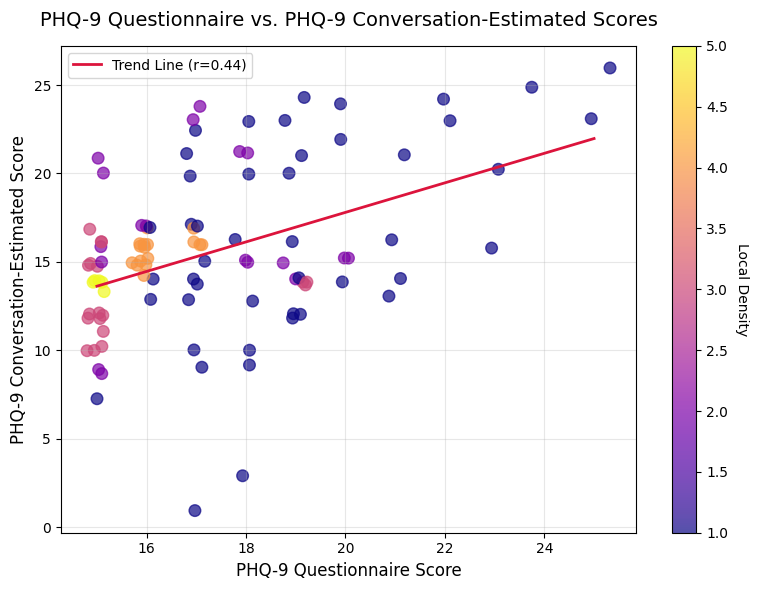

✅ PHQ9: scatter plot saved to: Graphs/Filtered_results\PHQ9_Score_vs_PHQ9_Estimate_Scatter_20251213_102701.png


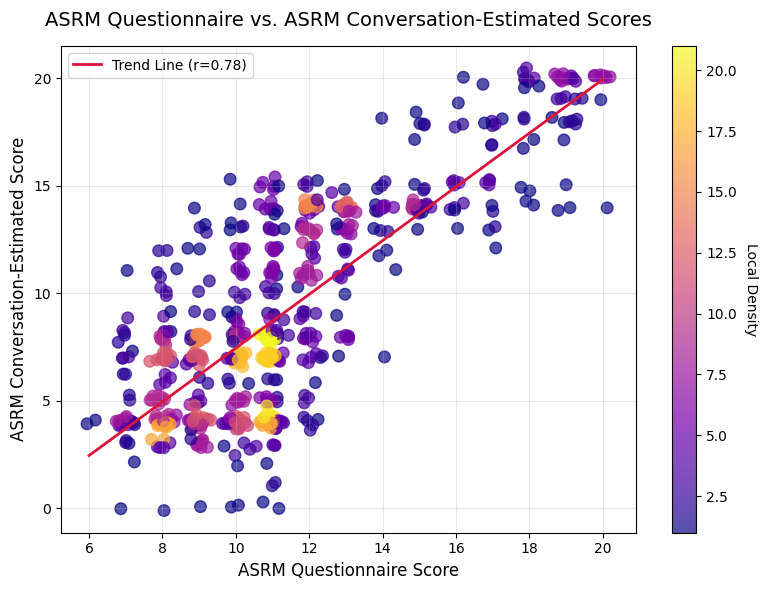

✅ ASRM: scatter plot saved to: Graphs/Filtered_results\ASRM_Score_vs_ASRM_Estimate_Scatter_20251213_102702.png


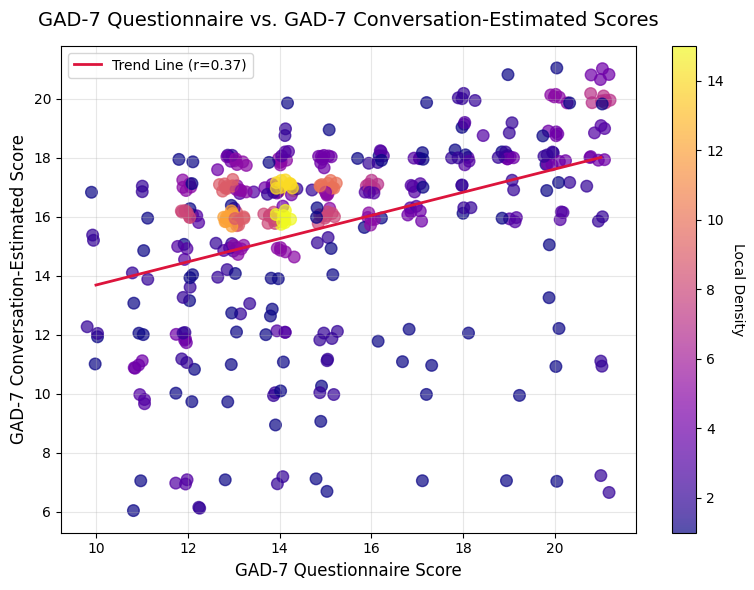

✅ GAD7: scatter plot saved to: Graphs/Filtered_results\GAD7_Score_vs_GAD7_Estimate_Scatter_20251213_102702.png


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

# --------------------------
# Config: input files & columns
# --------------------------
TASKS = [
    {
        "scale": "PHQ9",
        "csv": r"Analysis\Filtered\PHQ9_Severe.csv",
        "score_col": "PHQ9_Score",
        "est_col": "PHQ9_Estimate",
        "title": "PHQ-9 Questionnaire vs. PHQ-9 Conversation-Estimated Scores",
        "x_label": "PHQ-9 Questionnaire Score",
        "y_label": "PHQ-9 Conversation-Estimated Score",
    },
    {
        "scale": "ASRM",
        "csv": r"Analysis\Filtered\ASRM_Severe.csv",
        "score_col": "ASRM_Score",
        "est_col": "ASRM_Estimate",
        "title": "ASRM Questionnaire vs. ASRM Conversation-Estimated Scores",
        "x_label": "ASRM Questionnaire Score",
        "y_label": "ASRM Conversation-Estimated Score",
    },
    {
        "scale": "GAD7",
        "csv": r"Analysis\Filtered\GAD7_Severe.csv",
        "score_col": "GAD7_Score",
        "est_col": "GAD7_Estimate",
        "title": "GAD-7 Questionnaire vs. GAD-7 Conversation-Estimated Scores",
        "x_label": "GAD-7 Questionnaire Score",
        "y_label": "GAD-7 Conversation-Estimated Score",
    },
]

# --------------------------
# Output folder
# --------------------------
GRAPH_DIR = "Graphs/Filtered_results"
os.makedirs(GRAPH_DIR, exist_ok=True)

# --------------------------
# Plot loop (style exactly as your example)
# --------------------------
for task in TASKS:
    scale = task["scale"]
    csv_path = task["csv"]
    score_col = task["score_col"]
    est_col = task["est_col"]

    if not os.path.exists(csv_path):
        print(f"⚠️ Skipping {scale}: file not found -> {csv_path}")
        continue

    # --- Load ---
    df = pd.read_csv(csv_path)

    # --- Filter & clean ---
    if score_col not in df.columns or est_col not in df.columns:
        print(f"⚠️ Skipping {scale}: required columns missing in {csv_path}. Found: {list(df.columns)}")
        continue

    df = df.dropna(subset=[score_col, est_col])
    df = df[(df[score_col] >= 0) & (df[est_col] >= 0)]
    if df.empty:
        print(f"⚠️ Skipping {scale}: no valid rows after filtering.")
        continue

    # --- Correlation ---
    corr = df[score_col].corr(df[est_col])

    # --- Filename with timestamp ---
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_path = os.path.join(GRAPH_DIR, f"{scale}_Score_vs_{scale}_Estimate_Scatter_{timestamp}.png")

    # --- Jitter to reduce overlap ---
    rng = np.random.default_rng(42)
    df[f"{score_col}_jitter"] = df[score_col] + rng.normal(0, 0.15, len(df))
    df[f"{est_col}_jitter"]   = df[est_col]   + rng.normal(0, 0.15, len(df))

    # --- 2D histogram for density (no SciPy) ---
    counts, xedges, yedges = np.histogram2d(
        df[f"{score_col}_jitter"], df[f"{est_col}_jitter"], bins=25
    )
    x_idx = np.searchsorted(xedges, df[f"{score_col}_jitter"]) - 1
    y_idx = np.searchsorted(yedges, df[f"{est_col}_jitter"]) - 1
    x_idx = np.clip(x_idx, 0, counts.shape[0] - 1)
    y_idx = np.clip(y_idx, 0, counts.shape[1] - 1)
    density = counts[x_idx, y_idx]

    # --- Create scatter plot (no edgecolors) ---
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(
        df[f"{score_col}_jitter"], df[f"{est_col}_jitter"],
        c=density, s=70, cmap='plasma', alpha=0.7  # same style
    )

    # --- Regression line (on raw scores) ---
    m, b = np.polyfit(df[score_col], df[est_col], 1)
    # Sort for nicer line rendering
    xs = np.linspace(df[score_col].min(), df[score_col].max(), 100)
    ys = m * xs + b
    plt.plot(xs, ys, color="crimson", linewidth=2, label=f"Trend Line (r={corr:.2f})")

    # --- Labels, title, style ---
    plt.title(task["title"], fontsize=14, pad=15)
    plt.xlabel(task["x_label"], fontsize=12)
    plt.ylabel(task["y_label"], fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()

    # --- Colorbar ---
    cbar = plt.colorbar(sc)
    cbar.set_label("Local Density", rotation=270, labelpad=15)

    # --- Save & show ---
    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"✅ {scale}: scatter plot saved to: {out_path}")


#### Filtered Scores

In [2]:
# save as: export_only_scores.py
import pandas as pd
import os

# ---- Paths ----
INPUT_CSV  = r"Analysis/combined_sorted.csv"          # change if needed
OUTPUT_CSV = r"Analysis/Filtered/Only_Scores.csv"     # output path

# ---- Load ----
df = pd.read_csv(INPUT_CSV)

# ---- Flexible column resolution ----
def pick(df, aliases):
    """Return the first matching column name (case-insensitive) from aliases."""
    lower_map = {c.lower(): c for c in df.columns}
    for a in aliases:
        if a.lower() in lower_map:
            return lower_map[a.lower()]
    return None

name_col  = pick(df, ["Name", "name", "character", "Character", "persona"])
phq_col   = pick(df, ["PHQ9_Score", "phq9_score", "PHQ9", "phq9", "phq9_total"])
gad_col   = pick(df, ["GAD7_Score", "gad7_score", "GAD7", "gad7", "gad7_total"])
asrm_col  = pick(df, ["ASRM_Score", "asrm_score", "ASRM", "asrm", "asrm_total"])

missing = [lbl for lbl, col in {
    "Name": name_col, "PHQ9_Score": phq_col, "GAD7_Score": gad_col, "ASRM_Score": asrm_col
}.items() if col is None]

if missing:
    raise KeyError(f"Missing required columns ({', '.join(missing)}). Found: {list(df.columns)}")

# ---- Keep only scores; coerce to numeric and drop rows with all three scores missing ----
out = df[[name_col, phq_col, gad_col, asrm_col]].rename(columns={
    name_col: "Name",
    phq_col: "PHQ9_Score",
    gad_col: "GAD7_Score",
    asrm_col: "ASRM_Score"
})

for col in ["PHQ9_Score", "GAD7_Score", "ASRM_Score"]:
    out[col] = pd.to_numeric(out[col], errors="coerce")

# Drop rows where all three scores are NaN
out = out.dropna(subset=["PHQ9_Score", "GAD7_Score", "ASRM_Score"], how="all")

# Optional: keep only non-negative scores
out = out[
    (out["PHQ9_Score"].isna() | (out["PHQ9_Score"] >= 0)) &
    (out["GAD7_Score"].isna() | (out["GAD7_Score"] >= 0)) &
    (out["ASRM_Score"].isna() | (out["ASRM_Score"] >= 0))
].copy()

# ---- Save ----
os.makedirs(os.path.dirname(OUTPUT_CSV) or ".", exist_ok=True)
out.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")

print(f"Saved {len(out)} rows → {OUTPUT_CSV}")


Saved 733 rows → Analysis/Filtered/Only_Scores.csv
